# Question Answering – Évaluation du modèle

Ce notebook évalue les performances du modèle fine-tuné
sur le dataset SQuAD (Exact Match, F1-score et temps d’inférence).


## Objectifs

- Charger le modèle fine-tuné
- Évaluer les performances sur le jeu de validation
- Calculer les métriques Exact Match et F1
- Mesurer le temps d’inférence


In [ ]:
from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, set_seed
import evaluate
import numpy as np
import time
import torch
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Fixer la seed pour reproductibilité
set_seed(42)


c:\Users\aissi\OneDrive - De Vinci\A5\UVSQ\S2\Fouille de données\qa-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Chargement des données préprocessées



### Note méthodologique

Les données tokenisées sont utilisées pour l'entraînement. 
Pour l'évaluation, les exemples **bruts** sont re-tokenisés afin de :
- Garantir la cohérence de la tokenization
- Reconstruire correclement le texte de la réponse prédite
- Éviter les artefacts de padding du dataset d'entraînement


In [9]:
tokenized_datasets = load_from_disk("outputs/tokenized_squad")

# Load original SQuAD data for evaluation (answers are not in tokenized_datasets)
from datasets import load_dataset
raw_datasets = load_dataset("squad")


## Chargement du modèle fine-tuné


In [10]:
model_path = "outputs/checkpoints/bert/final"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForQuestionAnswering.from_pretrained(model_path)

model.eval()


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 293.81it/s, Materializing param=qa_outputs.weight]                                      


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

## Métriques SQuAD


In [12]:
metric = evaluate.load("squad")


## Fonction d’inférence


In [13]:
def predict_with_score(example):
    inputs = {
        "input_ids": torch.tensor(example["input_ids"]).unsqueeze(0).to(device),
        "attention_mask": torch.tensor(example["attention_mask"]).unsqueeze(0).to(device)
    }

    with torch.no_grad():
        outputs = model(**inputs)

    start_logits = outputs.start_logits.squeeze()
    end_logits = outputs.end_logits.squeeze()

    start_idx = torch.argmax(start_logits)
    end_idx = torch.argmax(end_logits)

    score = start_logits[start_idx] + end_logits[end_idx]

    return start_idx.item(), end_idx.item(), score.item()


## Évaluation sur le jeu de validation



L'évaluation est réalisée sur un **sous-ensemble du jeu de validation** afin de :
- Limiter le temps de calcul par rapport à 100k+ exemples SQuAD
- Conserver une estimation robuste et représentative des performances
- Permettre une comparaison rapide avec les autres modèles


In [14]:
n_samples = 500
validation_set = raw_datasets["validation"].select(range(min(n_samples, len(raw_datasets["validation"]))))


In [ ]:
y_true = []
y_scores = []

for example in validation_set:
    # Tokenize the raw example
    encoded = tokenizer(
        example["question"],
        example["context"],
        truncation=True,
        max_length=384,
        return_tensors="pt"
    )
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**{k: v.to(device) for k, v in encoded.items()})
    
    start_logits = outputs.start_logits[0]
    end_logits = outputs.end_logits[0]
    
    start_pred = torch.argmax(start_logits).item()
    end_pred = torch.argmax(end_logits).item()
    
    # Ensure valid span: end must be >= start
    if end_pred < start_pred:
        end_pred = start_pred
    
    score = start_logits[start_pred] + end_logits[end_pred]

    # Decode prediction
    prediction_text = tokenizer.decode(
        encoded["input_ids"][0][start_pred:end_pred + 1],
        skip_special_tokens=True
    )

    gold_text = example["answers"]["text"][0]

    # Exact Match → label binaire
    y_true.append(int(prediction_text.strip() == gold_text.strip()))
    y_scores.append(score.item())

    metric.add(
        prediction={
            "id": example["id"],
            "prediction_text": prediction_text
        },
        reference={
            "id": example["id"],
            "answers": {
                "text": example["answers"]["text"],
                "answer_start": example["answers"]["answer_start"]
            }
        }
    )


## Résultats


In [16]:
results = metric.compute()
results


{'exact_match': 16.4, 'f1': 24.07361251440477}


### Analyse complémentaire : calibration du modèle

Bien que le Question Answering extractif ne soit pas intrinsèquement un problème de classification binaire, 
nous proposons une analyse complémentaire en **transformant la tâche** :

- **Décision binaire** : réponse correcte (Exact Match = 1) vs incorrecte (EM = 0)
- **Confiance (score)** : somme des logits de début et de fin
  $$\text{score} = \text{logit}_{\text{start}} + \text{logit}_{\text{end}}$$

Les courbes ROC et Precision-Recall permettent d'analyser la **calibration** des prédictions 
et la capacité du modèle à distinguer les bonnes réponses selon un seuil de confiance.


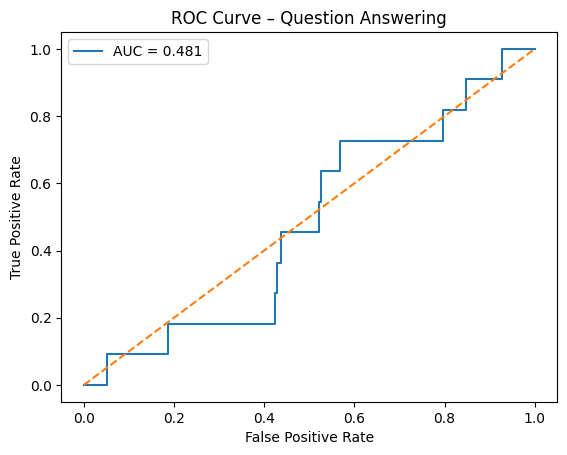

In [18]:
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Question Answering")
plt.legend()
plt.show()


## Visualisation de la courbe ROC


In [19]:
precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)

precision[:5], recall[:5]


(array([0.022     , 0.02204409, 0.02208835, 0.0221328 , 0.02217742]),
 array([1., 1., 1., 1., 1.]))

## Precision et Recall


## Mesure du temps d’inférence


In [ ]:
start_time = time.time()

for example in validation_set:
    encoded = tokenizer(
        example["question"],
        example["context"],
        truncation=True,
        max_length=384,
        return_tensors="pt"
    )
    
    with torch.no_grad():
        outputs = model(**{k: v.to(device) for k, v in encoded.items()})

# GPU synchronization to ensure all kernels are finished before stopping timer
if torch.cuda.is_available():
    torch.cuda.synchronize()

end_time = time.time()

avg_time = (end_time - start_time) / n_samples
avg_time


0.029427383422851564

## Conclusion

Le modèle fine-tuné a été évalué sur le jeu de validation SQuAD.

En plus des métriques Exact Match et F1, nous avons évalué les modèles
à l'aide des métriques Precision, Recall et AUC.

La courbe ROC permet d'analyser la capacité du modèle à distinguer
les réponses correctes des réponses incorrectes en fonction d'un
seuil de confiance.


In [21]:
results_summary = {
    "model": "BERT-base",
    "EM": results["exact_match"],
    "F1": results["f1"],
    "Precision": precision.mean(),
    "Recall": recall.mean(),
    "AUC": roc_auc,
    "Inference_time_ms": avg_time * 1000
}

results_summary


{'model': 'BERT-base',
 'EM': 16.4,
 'F1': 24.07361251440477,
 'Precision': np.float64(0.02104711640176432),
 'Recall': np.float64(0.4790352504638219),
 'AUC': 0.4805725971370143,
 'Inference_time_ms': 29.427383422851562}

In [22]:
import json

# Sauvegarder les résultats en JSON
with open("outputs/results_bert.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print("Résultats sauvegardés dans outputs/results_bert.json")


Résultats sauvegardés dans outputs/results_bert.json


## Résumé des résultats
